In [ ]:
#class cocodataset que va a ser igual que la que ya tenemos, leyendo distinto el archivo de labels

#visualizaciones

#armo el resnet + fc y lo entreno un poco

#metricas y analisis

## Creating the dataloader for the coco128 dataset

In [1]:
import os

import cv2
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms

from utils.util import xywhc2label

In [2]:
class COCO128Dataset(Dataset):
    def __init__(self, img_path, label_path, S, B, num_classes, transforms=None):
        self.img_path = img_path  # images folder path
        self.label_path = label_path  # labels folder path
        self.transforms = transforms
        self.filenames = [image for image in sorted(os.listdir(self.img_path)) if image[-4:]=='.jpg'][0:2]       
        self.S = S
        self.B = B
        self.num_classes = num_classes

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # read image
        img = cv2.imread(os.path.join(self.img_path, self.filenames[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # ori_width, ori_height = img.shape[1], img.shape[0]  # image's original width and height

        img = Image.fromarray(img).convert('RGB')
        img = self.transforms(img)  # resize and to tensor

        # read each image's corresponding label(.txt)
        xywhc = []
        with open(os.path.join(self.label_path, self.filenames[idx][:-4] + '.txt'), 'r') as f:
            lines = f.readlines()
            for line in lines:
                if line == '\n':
                    continue
                line = line.strip().split(' ')

                # convert xywh str to float, class str to int
                c, x, y, w, h = int(line[0]), float(line[1]), float(line[2]), float(line[3]), float(line[4])

                xywhc.append((x, y, w, h, c))

        label = xywhc2label(xywhc, self.S, self.B, self.num_classes)  # convert xywhc list to label
        label = torch.Tensor(label)
        return img, label


In [3]:
def create_dataloader(img_path, label_path, train_proportion, val_proportion, test_proportion, batch_size, input_size,
                      S, B, num_classes):
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor()
    ])

    # create yolo dataset
    dataset = COCO128Dataset(img_path, label_path, S, B, num_classes, transforms=transform)

    dataset_size = len(dataset)
    train_size = int(dataset_size * train_proportion)
    val_size = int(dataset_size * val_proportion)
    # test_size = int(dataset_size * test_proportion)
    test_size = dataset_size - train_size - val_size

    # split dataset to train set, val set and test set three parts
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # create data loader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [4]:
img_path = "data/coco128/train/"
label_path = "data/coco128/train/"
train_dataloader,_,_ = create_dataloader(img_path, label_path, 1, 0, 0, 
                                    batch_size = 2,
                                    input_size = 448,
                                    S=7,
                                    B=2,
                                    num_classes = 71)

#hacer lo mismo para val y test

In [5]:
from assertions import assert_labels_size
assert_labels_size(train_dataloader.dataset)

print("Dataset size:", len(train_dataloader.dataset))

 Correct label size  [7, 7, 81]
Dataset size: 2


In [6]:
# Building a dict for the class names

f = open("data/coco128/test/_darknet.labels")
class_dict = {}
index = 0
for line in f:
    class_dict[index] = line[:-1]
    index +=1

f.close()


## Visualizing the images and labels in the coco128 dataset

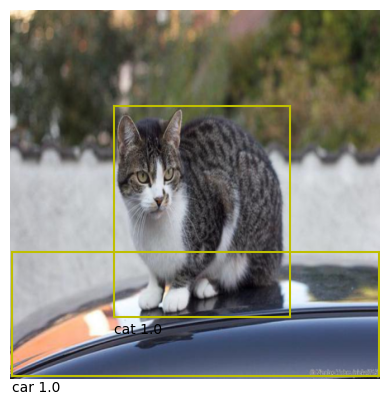

In [70]:
import draw_bbox as dbb

img, label = train_dataloader.dataset[33]
dbb.draw_img_and_bbox_from_true_labels(img, label, class_dict = class_dict) 

### Label distribution in dataset


In [11]:
def objects_found(model_output, threshold = 0.5):
    
    objects = []
    for i in range(7):
        for j in range(7):
            grid_labels = model_output[0,i,j,:]
            if object_is_present(grid_labels, threshold):
                objects.append(object_found(grid_labels))
    
    return objects

from draw_bbox import get_object_class

def object_is_present(grid_labels, threshold):
    return grid_labels[4] > threshold or grid_labels[9] > threshold

def object_found(grid_labels):
    return get_object_class(grid_labels[10:], class_dict)

In [14]:
all_objects = []

for img, label in train_dataloader.dataset:
    all_objects += objects_found(label.unsqueeze(0))

Text(0.5, 1.0, 'Most frequent labels')

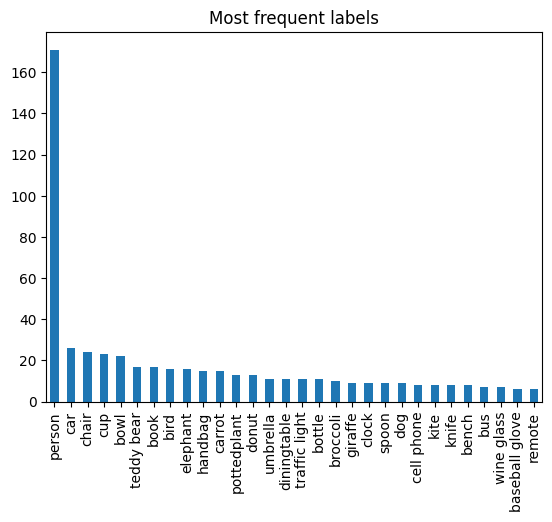

In [22]:
import matplotlib.pyplot as plt
import pandas as pd


pd.Series(all_objects).value_counts(sort=True)[0:30].plot(kind='bar')
plt.title("Most frequent labels")

In [23]:
number_of_labels_per_image = []

for img, label in train_dataloader.dataset:
    number_of_labels_per_image += [len(objects_found(label.unsqueeze(0)))]

Text(0.5, 1.0, 'Number of labels per image')

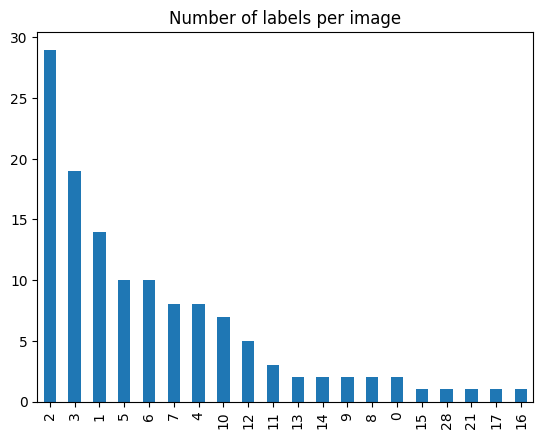

In [26]:
pd.Series(number_of_labels_per_image).value_counts(sort=True).plot(kind='bar')
plt.title("Number of labels per image")

## Benchmark model - Resnet + One fully connected layer

### Model instantiating and training

In [7]:
from yolo_nn_builders import YOLOResNetFullyConnected

torch.manual_seed(1)
model = YOLOResNetFullyConnected(7,2,71)

In [8]:
from train import train


S=7
B=2
train_loss_lst = []
output_path = "output/"

lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)#, momentum=0.9)#, weight_decay=0.0005)
#optimizer = torch.optim.Adam(model.parameters(), lr = lr)


In [9]:
number_of_epochs = 1

for epoch in range(number_of_epochs):
    train_features, train_labels = next(iter(train_dataloader))

In [11]:
epochs = 10
device = "cpu"

for epoch in range(epochs):
    train_loss_lst = train(model, train_dataloader, optimizer, epoch, device, S, B, train_loss_lst, output_path)

Train Epoch: 0 [0/2 (0.0%)]  Time: 1.4629s  Loss: 7.351485
Train Epoch: 1 [0/2 (0.0%)]  Time: 1.3422s  Loss: 7.640613
Train Epoch: 2 [0/2 (0.0%)]  Time: 1.4360s  Loss: 7.956334
Train Epoch: 3 [0/2 (0.0%)]  Time: 1.6551s  Loss: 7.920693
Train Epoch: 4 [0/2 (0.0%)]  Time: 1.5014s  Loss: 7.067467
Train Epoch: 5 [0/2 (0.0%)]  Time: 1.4676s  Loss: 7.965042
Train Epoch: 6 [0/2 (0.0%)]  Time: 1.5223s  Loss: 8.046043
Train Epoch: 7 [0/2 (0.0%)]  Time: 2.3983s  Loss: 7.847541
Train Epoch: 8 [0/2 (0.0%)]  Time: 1.5312s  Loss: 8.086565
Train Epoch: 9 [0/2 (0.0%)]  Time: 1.5041s  Loss: 8.081968


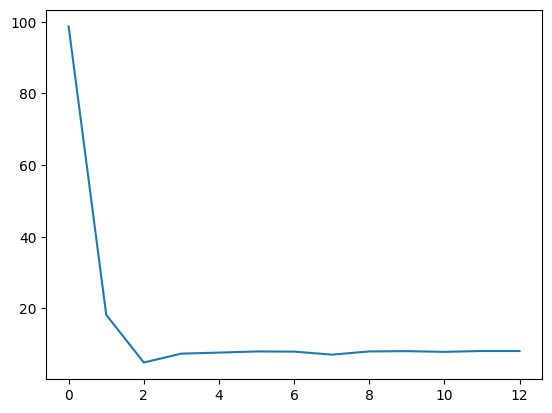

In [12]:
import matplotlib.pyplot as plt
plt.plot(train_loss_lst)

In [43]:
from utils.loss import YOLOv1Loss
loss = YOLOv1Loss(7,2)
img, label = train_dataloader.dataset[1]
loss(model(img.unsqueeze(0)),label.unsqueeze(0))

tensor(2.1556, grad_fn=<DivBackward0>)

In [23]:
for param in model.parameters():
    param.requires_grad=True

## Evaluating the model

In [57]:
torch.save(model.state_dict(), "output/toy_model.pth")

In [ ]:
# Load the model <- guardar y cargar el modelo podrian ser metodos aparte
toy_model = YOLOResNetFullyConnected(7,2,71)
toy_model.load_state_dict(torch.load("output/toy_model"))
toy_model.eval()

### Evaluating classes found

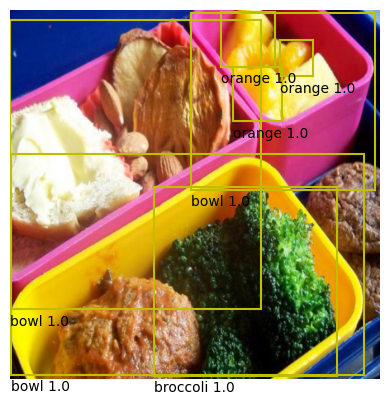

In [30]:
import draw_bbox as dbb

img, label = train_dataloader.dataset[0]
dbb.draw_img_and_bbox_from_true_labels(img, label, class_dict = class_dict) 

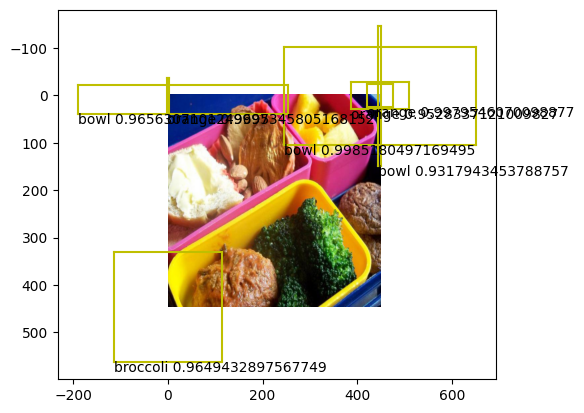

In [31]:
from draw_bbox import draw_prediction_grid_bbox, torch_to_pil
import matplotlib.pyplot as plt

with torch.inference_mode():
    pred = model(img.unsqueeze(0))
fig, ax = plt.subplots()
ax.imshow(torch_to_pil(img))
for i in range(7):
    for j in range(7):
        draw_prediction_grid_bbox(pred[0,i,j,:], ax, class_dict = class_dict)

In [39]:
for i in range(7):
    for j in range(7):
        print(i,j,label[i,j, 0:2])
        print(i,j, pred.squeeze(0)[i,j, 0:2])

0 0 tensor([0., 0.])
0 0 tensor([0.9654, 0.0489])
0 1 tensor([0., 0.])
0 1 tensor([0.0155, 0.4534])
0 2 tensor([0., 0.])
0 2 tensor([0.2263, 0.8277])
0 3 tensor([0., 0.])
0 3 tensor([0.8264, 0.4751])
0 4 tensor([0.6430, 0.0789])
0 4 tensor([0.0010, 0.0030])
0 5 tensor([0.7734, 0.1305])
0 5 tensor([0.7360, 0.6666])
0 6 tensor([0., 0.])
0 6 tensor([0.9387, 0.9850])
1 0 tensor([0., 0.])
1 0 tensor([0.6744, 0.9585])
1 1 tensor([0., 0.])
1 1 tensor([0.0515, 0.5254])
1 2 tensor([0., 0.])
1 2 tensor([0.8911, 0.8852])
1 3 tensor([0., 0.])
1 3 tensor([0.0778, 0.3323])
1 4 tensor([0.6680, 0.2273])
1 4 tensor([0.7281, 0.9334])
1 5 tensor([0.7367, 0.2469])
1 5 tensor([0.9991, 0.0047])
1 6 tensor([0., 0.])
1 6 tensor([0.5484, 0.9622])
2 0 tensor([0., 0.])
2 0 tensor([0.6139, 0.0759])
2 1 tensor([0., 0.])
2 1 tensor([0.0430, 0.1719])
2 2 tensor([0.3391, 0.4187])
2 2 tensor([4.0323e-10, 9.9914e-01])
2 3 tensor([0., 0.])
2 3 tensor([0.1069, 0.8964])
2 4 tensor([0., 0.])
2 4 tensor([0.1378, 0.4391])
2 

In [20]:
def objects_found(model_output, threshold = 0.5):
    
    objects = []
    for i in range(7):
        for j in range(7):
            grid_labels = model_output[0,i,j,:]
            if object_is_present(grid_labels, threshold):
                objects.append(object_found(grid_labels))
    
    return objects

from draw_bbox import get_object_class

def object_is_present(grid_labels, threshold):
    return grid_labels[4] > threshold or grid_labels[9] > threshold

def object_found(grid_labels):
    return get_object_class(grid_labels[10:], class_dict)

In [21]:
# Identifying when objects are detected
for img, label in train_dataloader.dataset:
    current_objects = objects_found(model(img.unsqueeze(0)), threshold= 0.5)
    if current_objects != []:
        print(current_objects)


['orange', 'orange', 'orange', 'bowl', 'bowl', 'bowl', 'broccoli']
['giraffe', 'giraffe']


In [22]:
correct = 0
n = len(train_dataloader.dataset)
for img, label in train_dataloader.dataset:
    true_objects = objects_found(label.unsqueeze(0))
    pred_objects = objects_found(model(img.unsqueeze(0)))
    if sorted(true_objects) == sorted(pred_objects):
        correct +=1
        print(true_objects)
print(correct/n)

['orange', 'orange', 'orange', 'bowl', 'bowl', 'bowl', 'broccoli']
['giraffe', 'giraffe']
1.0


### Funcion avg smooth loss para implementar despues

In [4]:
class AvgSmoothLoss:
    "Smooth average of the losses (exponentially weighted with `beta`)"
    def __init__(self, beta=0.98): 
        self.beta = beta

    def reset(self):               
        self.count, self.val = 0, torch.tensor(0.)

    def accumulate(self, value):
        self.count += 1
        self.val = torch.lerp(value, self.val, self.beta)
    @property
    def value(self): return self.val/(1-self.beta**self.count)

In [9]:
import torch
loss = AvgSmoothLoss()
loss.reset()

In [14]:
loss.accumulate(torch.tensor(20.))

In [17]:
loss.value

tensor(8.2024)